In [ ]:
# Connect Colab Notebook to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Activate virtual environment inside the Google drive
!source /content/drive/MyDrive/colab_env/bin/activate;

In [ ]:
# Add a path for Python to install and import packages into the activated virtual environment
import sys
sys.path.append('/content/drive/MyDrive/colab_env/lib/python3.10/site-packages')

In [ ]:
# Install stable_baselines3 and gym_trading_env libraries
%pip install stable_baselines3
%pip install gym_trading_env

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.7/288.7 kB 20.5 MB/s eta 0:00:00


In [ ]:
# Copy the file .py modules from the specified path in Google Drive to the current working directory in Colab
!cp "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/history.py" .
!cp "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/portfolio.py" .
!cp "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/data_processor.py" .
!cp "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/environments.py" .

In [ ]:
# Importing necessary libraries for numerical operations and data manipulation
import numpy as np
import pandas as pd

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Ensuring that plots are displayed inline within Jupyter notebooks
%matplotlib inline

In [ ]:
# Importing reinforcement learning algorithms and noise processes from stable_baselines3
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

# Importing utility for creating vectorized environments
from stable_baselines3.common.vec_env import DummyVecEnv

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Importing utilities for displaying output and managing time
from IPython.display import clear_output
import time

# Importing libraries for handling dates, file paths, and directories
import datetime
import glob
from pathlib import Path

# Importing collections for counting elements
from collections import Counter

# Importing gym_trading_env modules for handling historical data and portfolio management
from history import History
from portfolio import Portfolio, TargetPortfolio

# Importing gymnasium for creating and managing reinforcement learning environments
import gymnasium as gym
from gymnasium import spaces
import gymnasium
import gym_trading_env

# Importing libraries for creating temporary files and interacting with the operating system
import tempfile, os

# Importing custom modules for creating trading environments and processing data
from environments import TradingEnv
from data_processor import data_func, state_space, simulator_descrete, Visual_Simulator, Universal_Simulator

In [ ]:
# Defining the file paths for GBPUSD daily, weekly, monthly and US Dollar Index (DXY) daily data
gu_daily_path = "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/data/GBPUSD=X daily.csv"
gu_weekly_path = "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/data/GBPUSD=X weekly.csv"
gu_monthly_path = "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/data/GBPUSD=X monthly.csv"
dxy_daily_path = "/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/data/DX-Y.NYB daily.csv"

# Calling the data_func function to process the data from the specified file paths
Data = data_func(gu_daily_path, gu_weekly_path, gu_monthly_path, dxy_daily_path, daily_only=False)

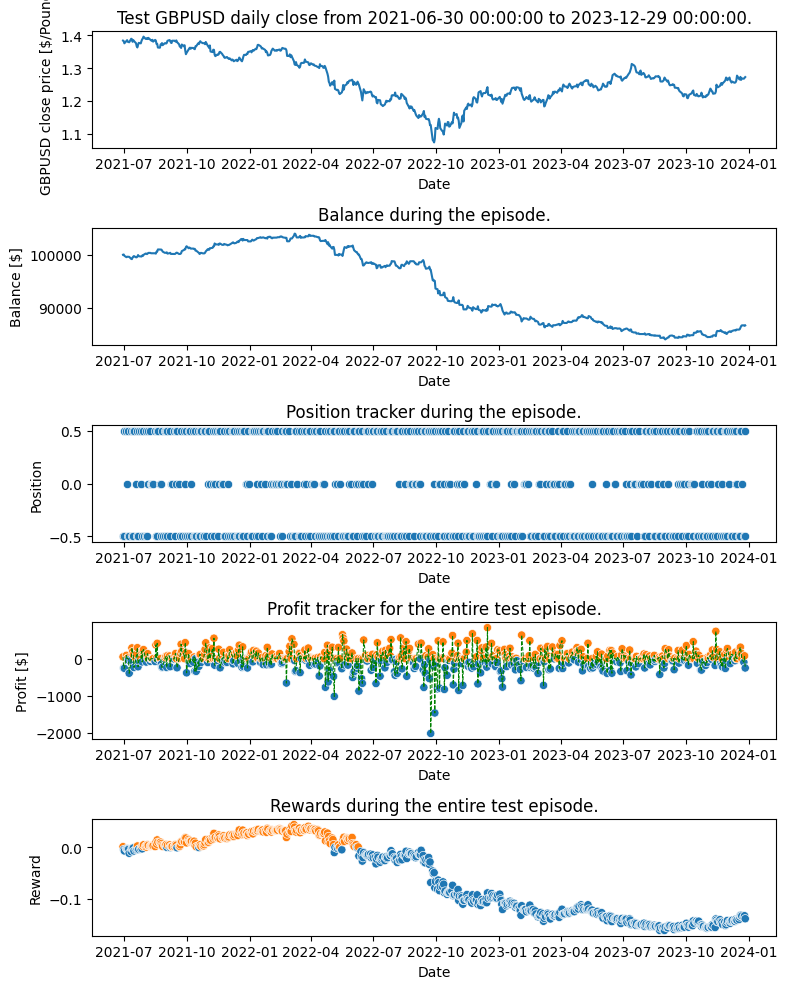

In [ ]:
# Visualise test simulation
Visual_Simulator(Data, 'ppo', 'macd')

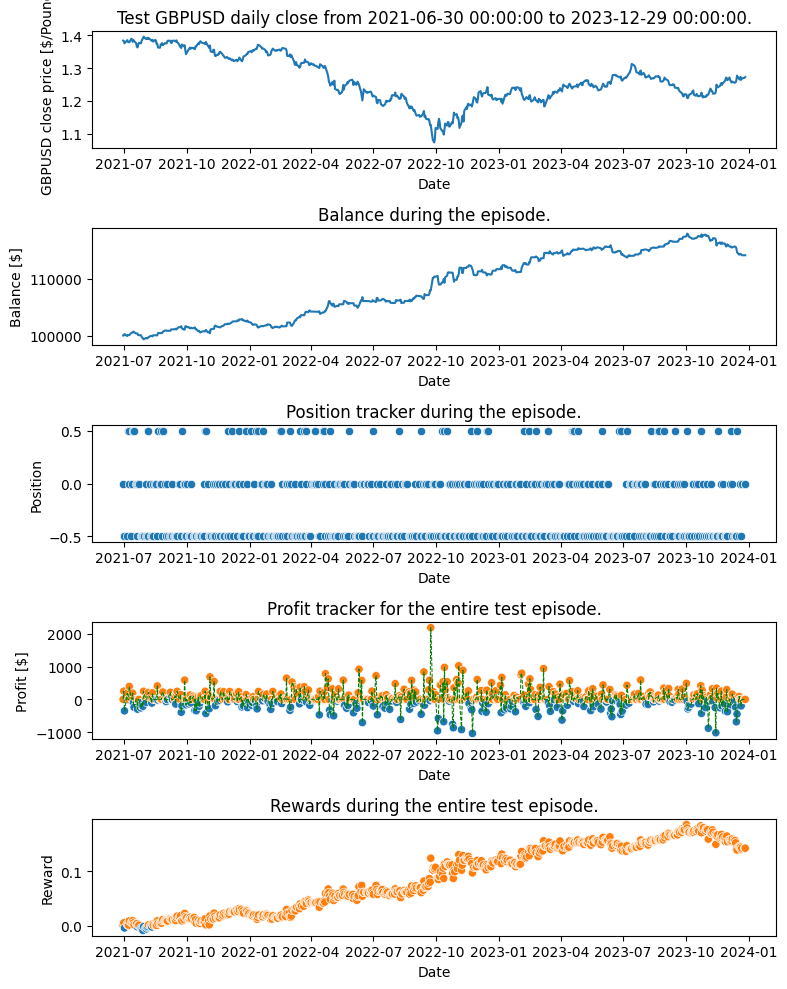

In [ ]:
# Visualise test simulation
Visual_Simulator(Data, 'ppo', 'dxy')

In [ ]:
def Metrics_sim(Data, model, strategy):

  # Annual yield (US Treasury yield)
  annual_yield = 2.75

  n = 25
  returns = []
  sharpes = []
  annualised_returns = []
  max_drawdowns = []

  for i in range(n):
    df = Universal_Simulator(Data, model, strategy)
    # Returns
    return_ = ((df['balance_tracker'][-1] - df['balance_tracker'][0])/df['balance_tracker'][0])*100

    #Sharpe_ratio
    # Calculate daily returns
    df['daily_return'] = df['balance_tracker'].pct_change()
    # Calculate the average daily return
    average_daily_return = df['daily_return'].mean()
    # Calculate the standard deviation of daily returns
    std_dev_daily_return = df['daily_return'].std()
    # Convert the annual risk-free rate to a daily risk-free rate
    risk_free_rate_annual = annual_yield/100
    risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1/252) - 1
    # Calculate the Sharpe ratio
    sharpe_ratio = (average_daily_return - risk_free_rate_daily) / std_dev_daily_return

    # Calculate the annualized return
    annualised_return = (df['balance_tracker'].iloc[-1] / df['balance_tracker'].iloc[0]) ** (12 / 18) - 1

    #Maximum drawdown
    # Calculate cumulative returns
    cumulative_returns = df['balance_tracker'] / df['balance_tracker'].iloc[0]
    # Find the running maximum
    running_max = cumulative_returns.cummax()
    # Calculate drawdown
    drawdown = (cumulative_returns - running_max) / running_max
    # Find the maximum drawdown
    max_drawdown = drawdown.min()

    # Calculate the annualised return
    returns.append(np.round(return_, 2))
    sharpes.append(np.round(sharpe_ratio, 3))
    annualised_returns.append(np.round(annualised_return*100, 2))
    max_drawdowns.append(np.round(max_drawdown*100, 3))

  # Convert to arrays
  returns = np.array(returns)
  sharpes = np.array(sharpes)
  annualised_returns = np.array(annualised_returns)
  max_drawdowns = np.array(max_drawdowns)
  return returns, sharpes, annualised_returns, max_drawdowns

In [ ]:
# Call Metrics function and save results
results = Metrics_sim(Data, 'dqn', 'ewm')

Market Return : -7.53%   |   Portfolio Return :  2.66%   |   


- Sharpe +
- Returns +
- Annualised returns +
- Maximum drawdown +

In [ ]:
# Create dataframe of results
results_df = pd.concat([pd.Series(i) for i in results], axis=1)
# Name columns in dataframe
results_df.columns = ['Returns', 'Sharpes', 'Annualised Returns', 'Maximum Drawdowns']

In [ ]:
# Show first 3 entries in dataframe
results_df.head(3)

,Returns,Sharpes,Annualised Returns,Maximum Drawdowns
0,4.57,-0.011,3.03,-7.987
1,3.91,-0.015,2.59,-9.886
2,-0.82,-0.040,-0.55,-10.703


In [ ]:
# Save results dataframe to CSV file
#results_df.to_csv('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/simulation results/dqn_ewm.csv')

<Axes: >

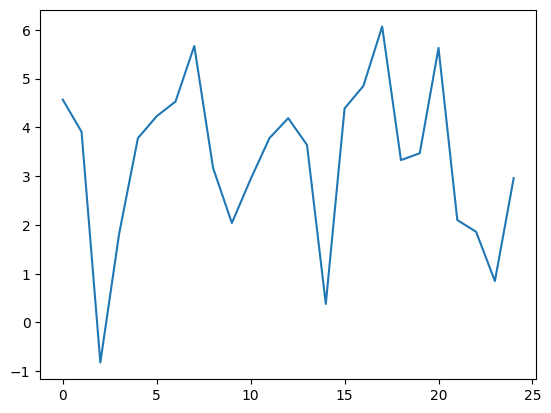

In [ ]:
# Show distribution of percentage returns
results_df['Returns'].plot()

In [ ]:
len(results_df)

25

In [ ]:
import pandas as pd
import os

def get_results():
  # Path to results folder
  folder_path = '/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/simulation results'

  # Initialise an empty DataFrame to store the extracted columns
  returns_df = pd.DataFrame()
  sharpes_df = pd.DataFrame()
  annualised_returns_df = pd.DataFrame()
  max_drawdowns_df = pd.DataFrame()

  # Iterate through each CSV file in the specified folder
  for filename in os.listdir(folder_path):
      if filename.endswith('.csv'):
          # Read the CSV file into a DataFrame
          df = pd.read_csv(os.path.join(folder_path, filename))

          # Extract the first column and rename it after the filename
          column_name = filename[:-4]  # Remove the '.csv' extension
          returns_df[column_name] = df.iloc[:, 1]
          sharpes_df[column_name] = df.iloc[:, 2]
          annualised_returns_df[column_name] = df.iloc[:, 3]
          max_drawdowns_df[column_name] = df.iloc[:, 4]

  return returns_df, sharpes_df, annualised_returns_df, max_drawdowns_df


In [ ]:
# Save respective metrics from the extraction function get_results
returns_df, sharpes_df, annualised_returns_df, max_drawdowns_df = get_results()

In [ ]:
returns_df.head(3)

,ppo_dxy,dqn_dxy,ppo_mtf_2,dqn_mtf_2,ppo_mtf_1,dqn_mtf_1,ppo_lstm,dqn_lstm,ppo_SR_2,dqn_SR_2,ppo_SR_1,dqn_SR_1,ppo_rsi,dqn_rsi,ppo_bb,dqn_bb,ppo_macd,dqn_macd,ppo_ewm,dqn_ewm
0,1.41,6.67,3.98,2.24,-2.01,4.00,-2.10,0.31,4.03,7.08,2.91,8.09,-2.80,3.52,1.95,-9.15,0.34,2.78,1.78,4.57
1,-3.49,1.56,3.55,4.63,8.57,3.81,3.31,3.19,4.75,3.71,5.19,4.19,-2.79,5.15,-0.59,-7.68,5.13,-1.14,-8.96,3.91
2,-1.87,1.50,3.98,7.05,4.00,5.08,0.47,3.35,3.90,1.24,1.19,3.49,4.98,3.00,6.84,3.03,-5.83,3.15,0.91,-0.82


In [ ]:
# PPO models in the returns_df
ppo_models = ['ppo_dxy', 'ppo_mtf_2', 'ppo_mtf_1', 'ppo_lstm', 'ppo_SR_2', 'ppo_SR_1', 'ppo_ewm', 'ppo_macd', 'ppo_bb', 'ppo_rsi']

# DQN models in the returns_df
dqn_models = ['dqn_dxy', 'dqn_mtf_2', 'dqn_mtf_1', 'dqn_lstm', 'dqn_SR_2', 'dqn_SR_1', 'dqn_ewm', 'dqn_macd', 'dqn_bb', 'dqn_rsi']

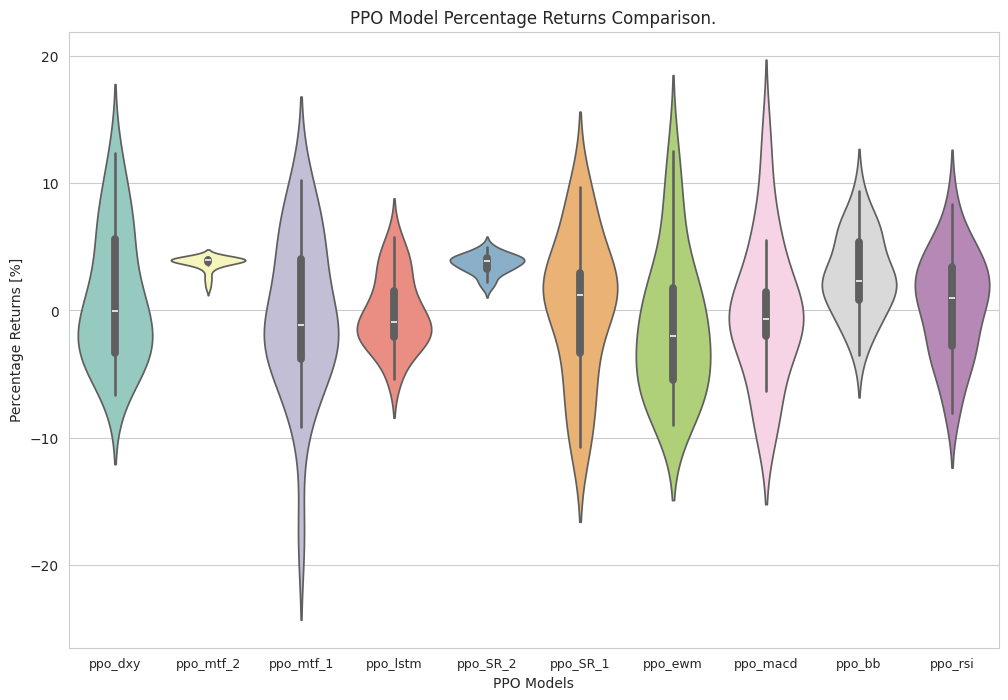

In [ ]:
# Plot graph
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.violinplot(data=returns_df[ppo_models], palette='Set3')
plt.title('PPO Model Percentage Returns Comparison.')
plt.ylabel('Percentage Returns [%]')
plt.xlabel('PPO Models')
plt.xticks(fontsize=9)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/pr_ppo.svg')
plt.show()

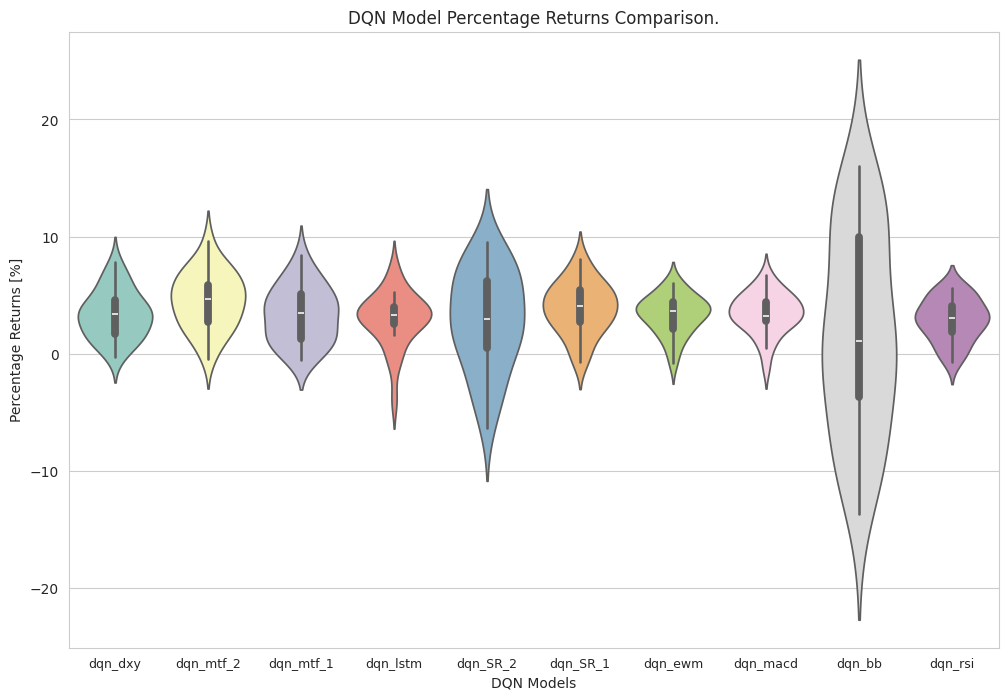

In [ ]:
# Plot graph
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.violinplot(data=returns_df[dqn_models], palette='Set3')
plt.title('DQN Model Percentage Returns Comparison.')
plt.ylabel('Percentage Returns [%]')
plt.xlabel('DQN Models')
plt.xticks(fontsize=9)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/pr_dqn.svg')
plt.show()

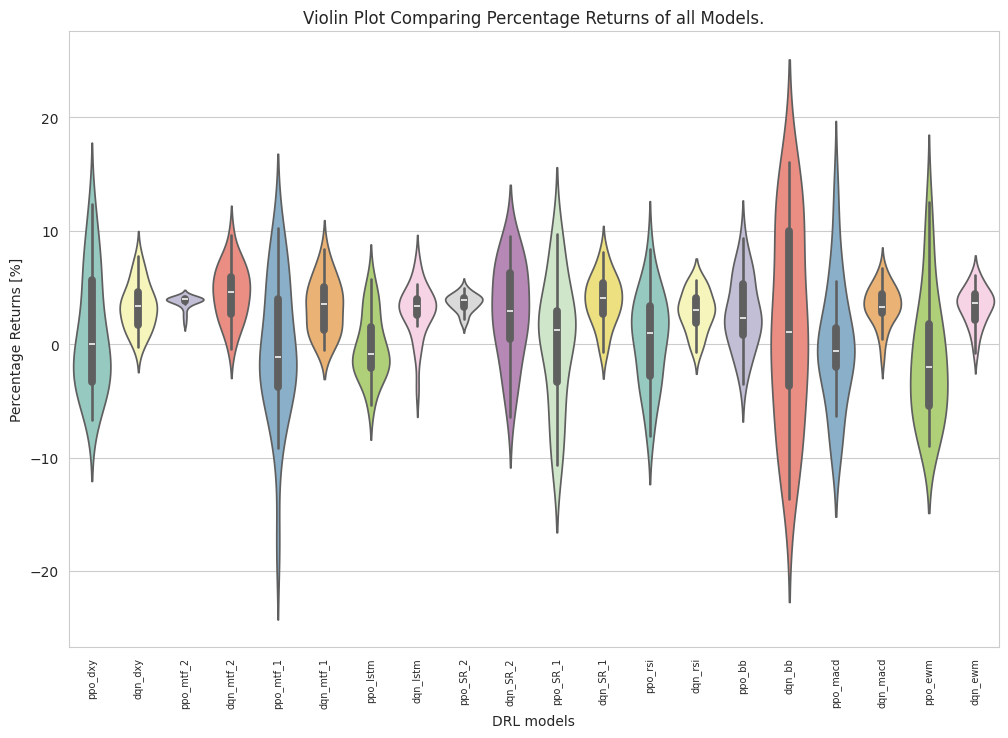

In [ ]:
# Plot graph
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.violinplot(data=returns_df, palette='Set3')
plt.title('Violin Plot Comparing Percentage Returns of all Models.')
plt.ylabel('Percentage Returns [%]')
plt.xlabel('DRL models')
plt.xticks(rotation=90, fontsize=7)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/pr_drl.svg')
plt.show()

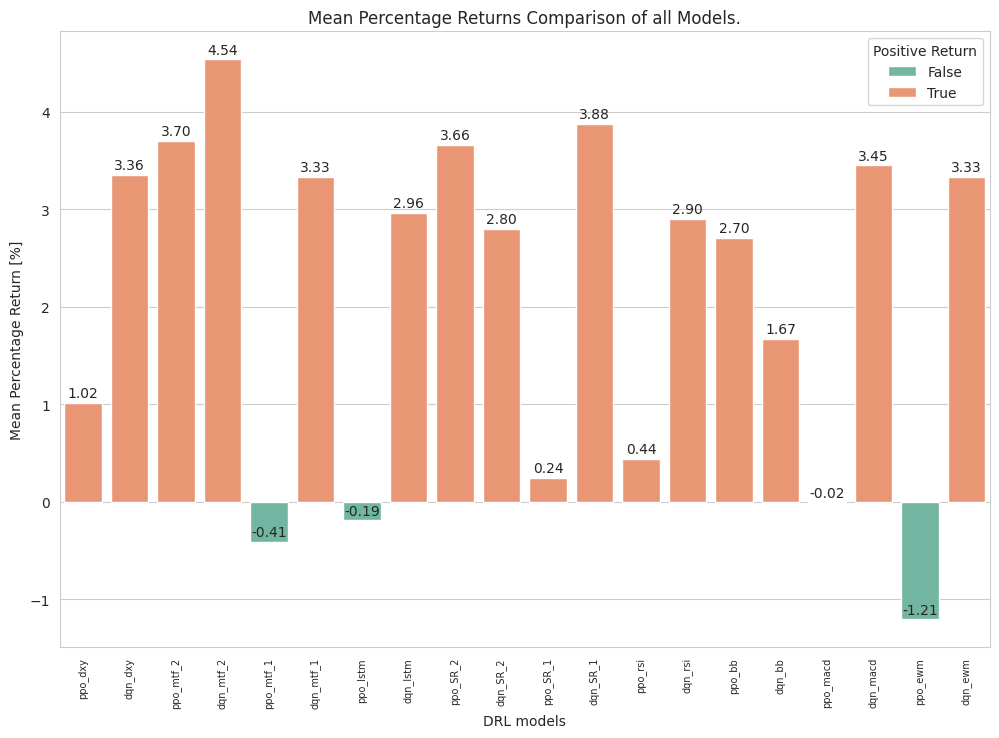

In [ ]:
# Calculate the mean of each column
means = returns_df.mean()

# Create a bar plot
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=means.index, y=means.values, hue= means>0, palette='Set2')

# Add mean annotations for all bars
for bar in ax.containers:
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 2 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Plot graph
plt.title('Mean Percentage Returns Comparison of all Models.')
plt.ylabel('Mean Percentage Return [%]')
plt.legend(title='Positive Return')
plt.xlabel('DRL models')
plt.xticks(rotation=90, fontsize=7)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/mpr_drl.svg')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


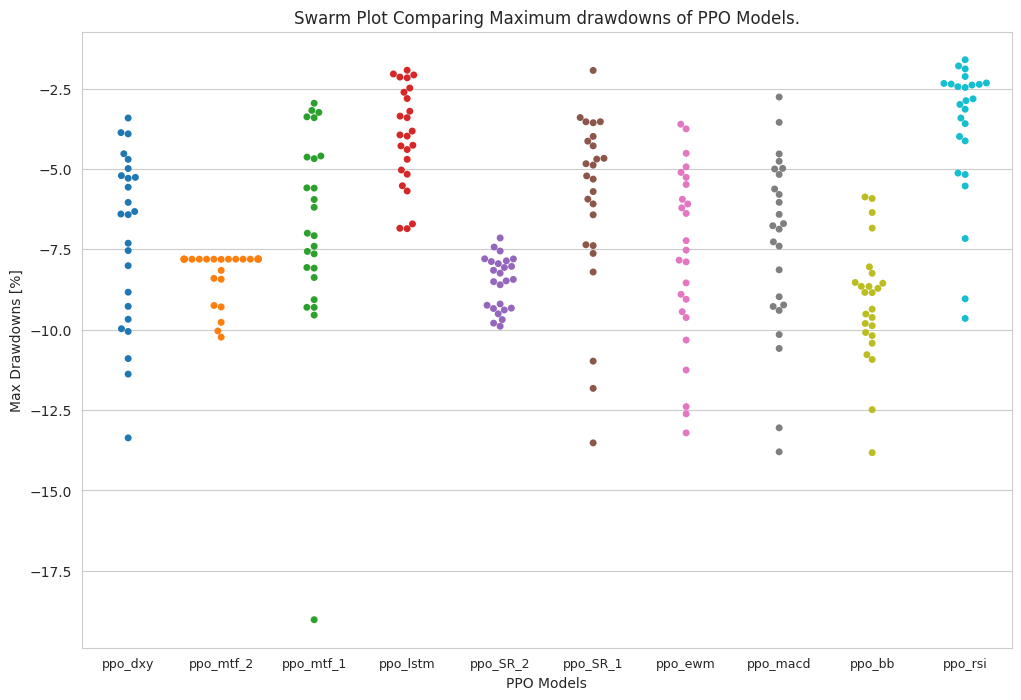

In [ ]:
# Plot graph
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.swarmplot(data=max_drawdowns_df[ppo_models])
plt.title('Swarm Plot Comparing Maximum drawdowns of PPO Models.')
plt.ylabel('Max Drawdowns [%]')
plt.xlabel('PPO Models')
plt.xticks(fontsize=9)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/md_ppo.svg')
plt.show()

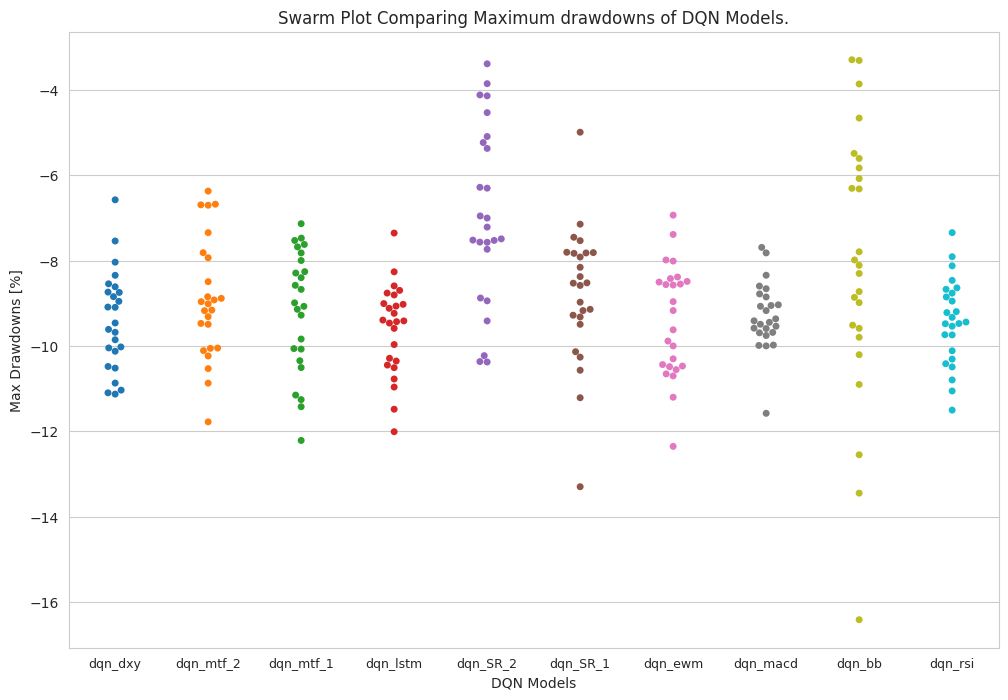

In [ ]:
# Plot graph
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.swarmplot(data=max_drawdowns_df[dqn_models])
plt.title('Swarm Plot Comparing Maximum drawdowns of DQN Models.')
plt.ylabel('Max Drawdowns [%]')
plt.xlabel('DQN Models')
plt.xticks(fontsize=9)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/md_dqn.svg')
plt.show()

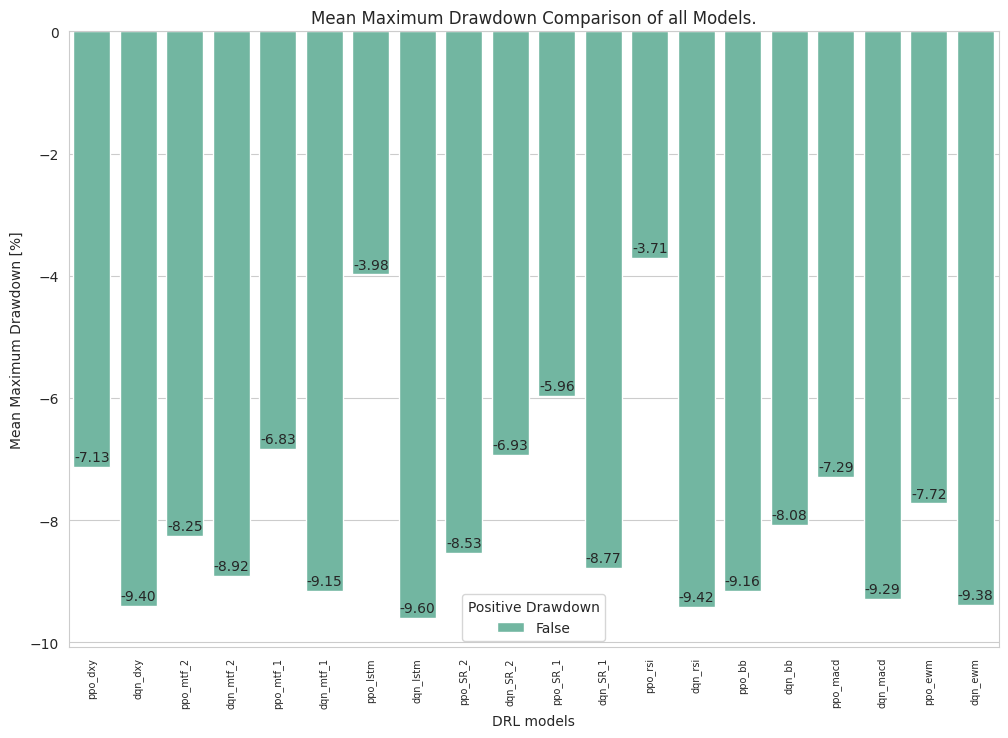

In [ ]:
# Calculate the mean of each column
means = max_drawdowns_df.mean()

# Create a bar plot
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=means.index, y=means.values, hue= means>0, palette='Set2')

# Add mean annotations for all bars
for bar in ax.containers:
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 2 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
# Plot graph
plt.title('Mean Maximum Drawdown Comparison of all Models.')
plt.ylabel('Mean Maximum Drawdown [%]')
plt.xlabel('DRL models')
plt.legend(title='Positive Drawdown')
plt.xticks(rotation=90, fontsize=7)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/mmd_drl.svg')
plt.show()

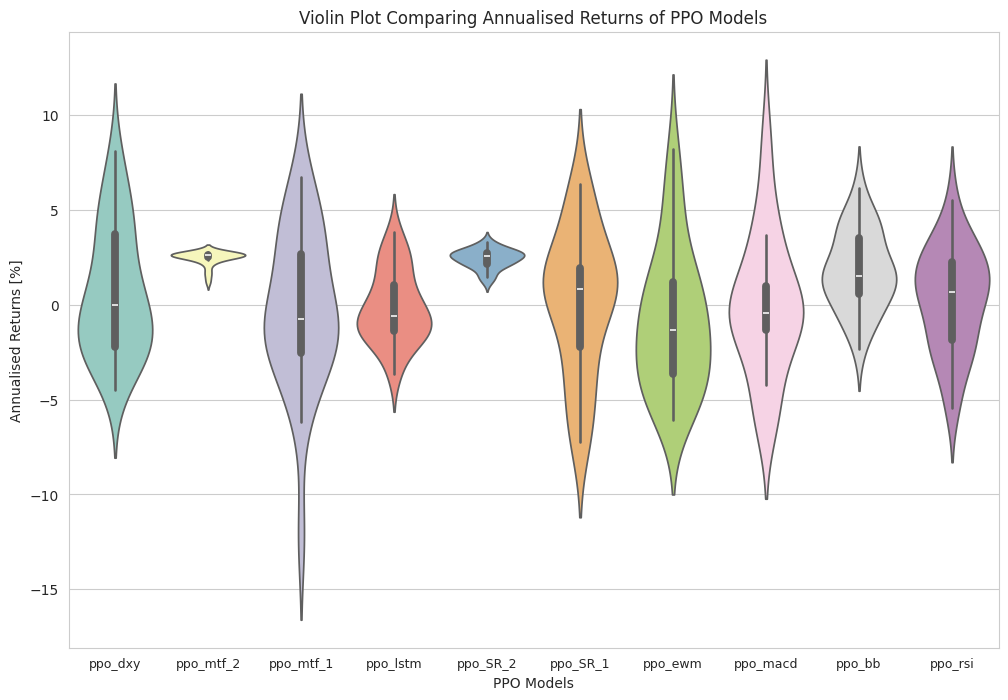

In [ ]:
# Plot graph
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
# PPO models
sns.violinplot(data=annualised_returns_df[ppo_models], palette='Set3')
plt.title('Violin Plot Comparing Annualised Returns of PPO Models')
plt.ylabel('Annualised Returns [%]')
plt.xlabel('PPO Models')
plt.xticks(fontsize=9)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/ar_ppo.svg')
plt.show()

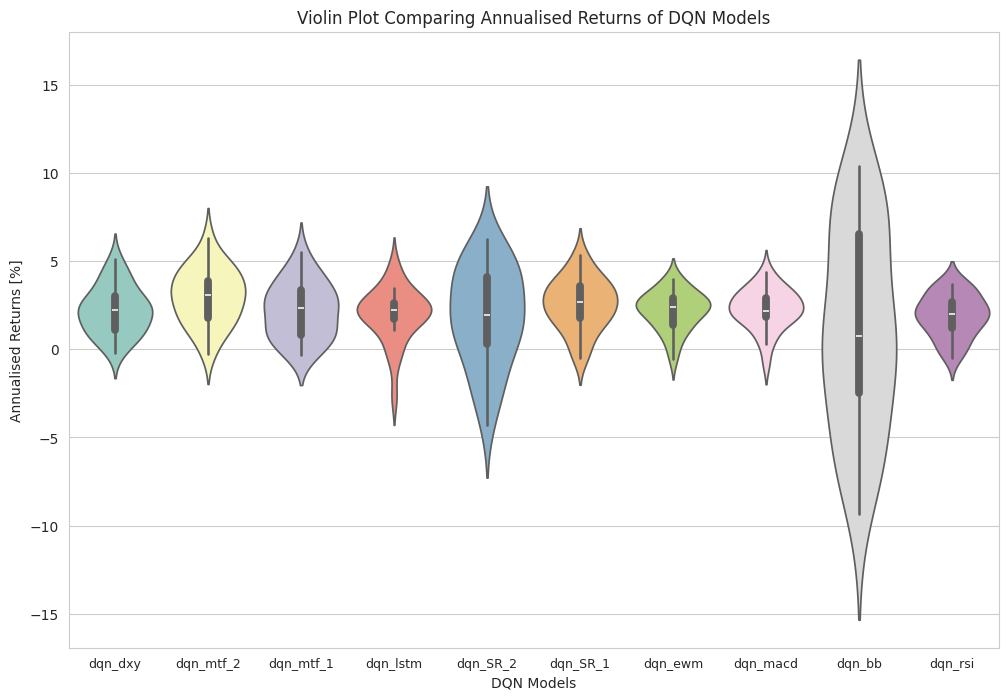

In [ ]:
# Plot graph
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
# DQN models
sns.violinplot(data=annualised_returns_df[dqn_models], palette='Set3')
plt.title('Violin Plot Comparing Annualised Returns of DQN Models')
plt.ylabel('Annualised Returns [%]')
plt.xlabel('DQN Models')
plt.xticks(fontsize=9)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/ar_dqn.svg')
plt.show()

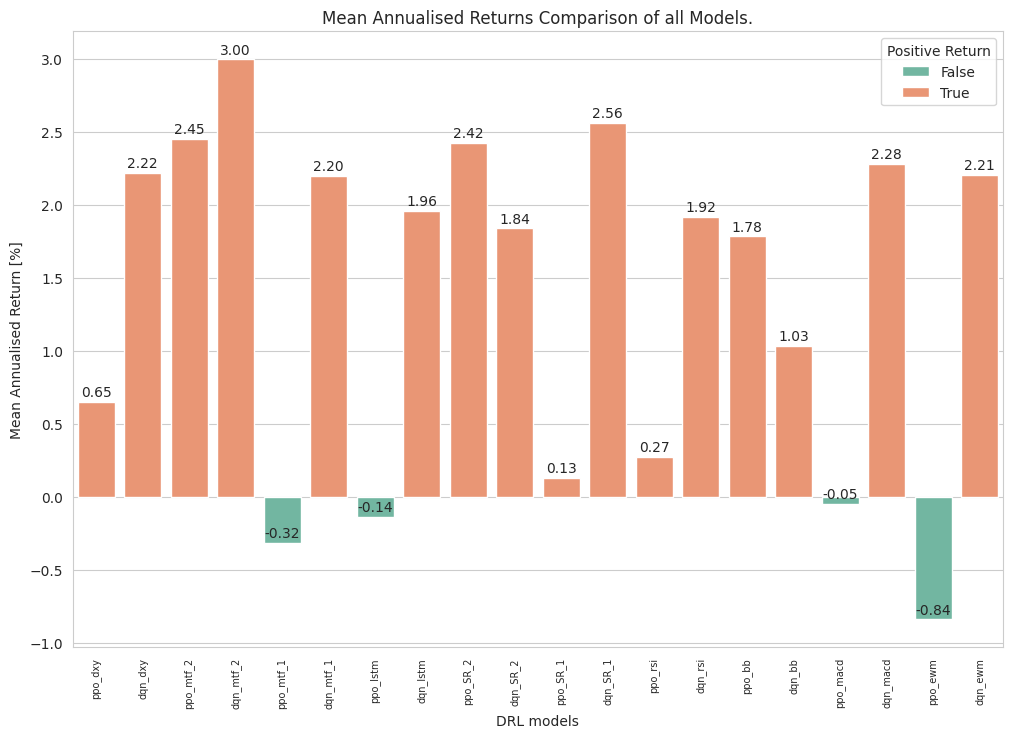

In [ ]:
# Calculate the mean of each column
means = annualised_returns_df.mean()

# Create a bar plot
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=means.index, y=means.values, hue= means>0, palette='Set2')

# Add mean annotations for all bars
for bar in ax.containers:
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 2 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Plot graph
plt.title('Mean Annualised Returns Comparison of all Models.')
plt.ylabel('Mean Annualised Return [%]')
plt.legend(title='Positive Return')
plt.xlabel('DRL models')
plt.xticks(rotation=90,fontsize=7)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/mar_drl.svg')
plt.show()

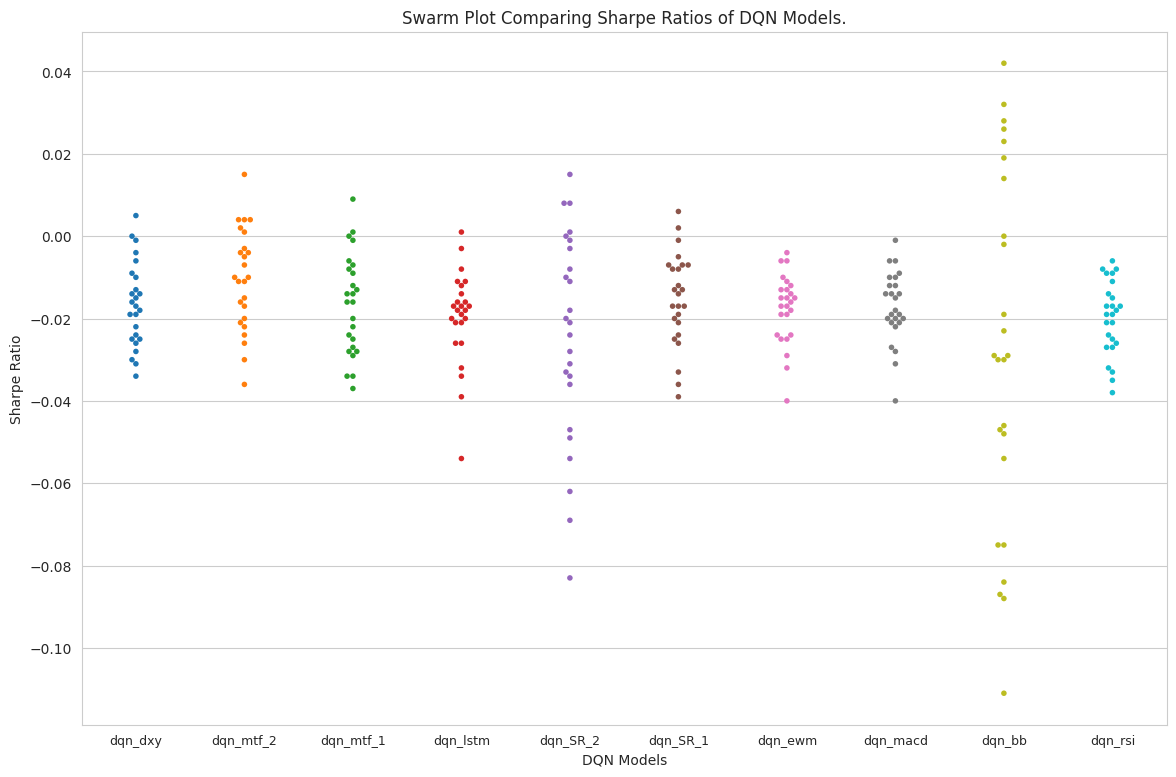

In [ ]:
# Plot graph
sns.set_style('whitegrid')
plt.figure(figsize=(14, 9))
sns.swarmplot(data=sharpes_df[dqn_models], size=4)
plt.title('Swarm Plot Comparing Sharpe Ratios of DQN Models.')
plt.ylabel('Sharpe Ratio')
plt.xlabel('DQN Models')
plt.xticks(fontsize=9)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/sharpes_dqn.svg')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


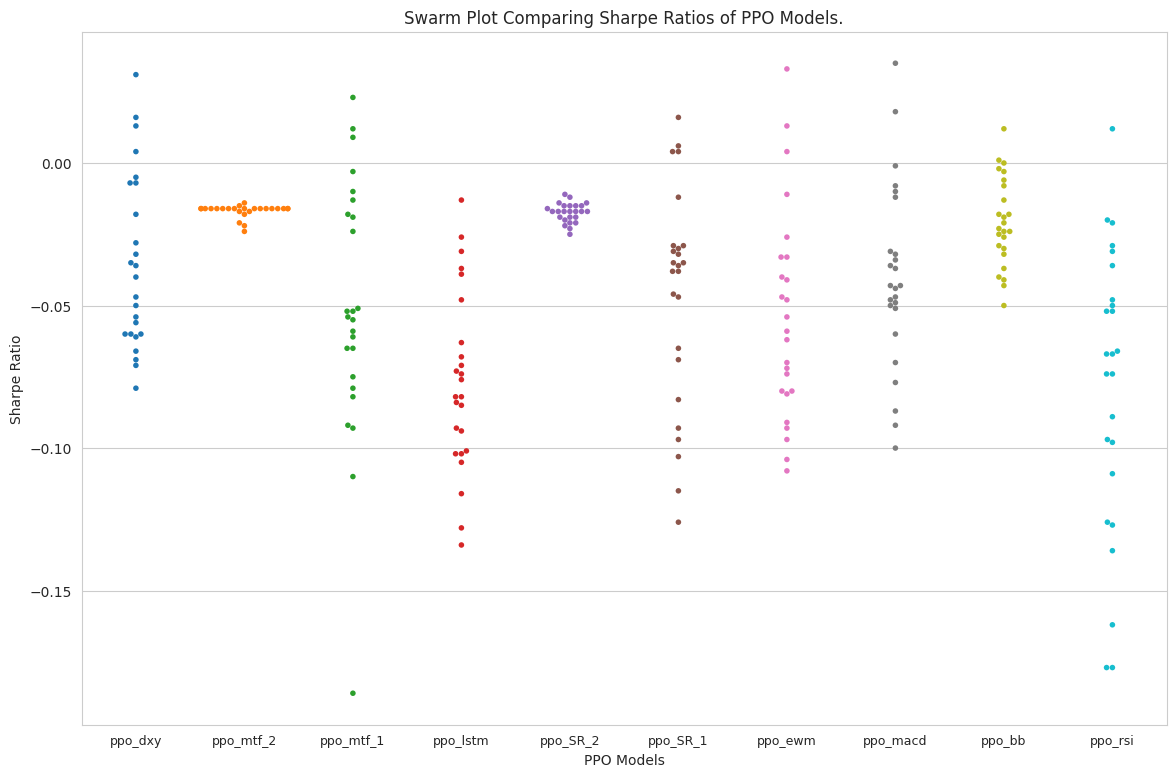

In [ ]:
# Plot graph
sns.set_style('whitegrid')
plt.figure(figsize=(14, 9))
sns.swarmplot(data=sharpes_df[ppo_models], size=4)
plt.title('Swarm Plot Comparing Sharpe Ratios of PPO Models.')
plt.ylabel('Sharpe Ratio')
plt.xlabel('PPO Models')
plt.xticks(fontsize=9)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/sharpes_ppo.svg')
plt.show()

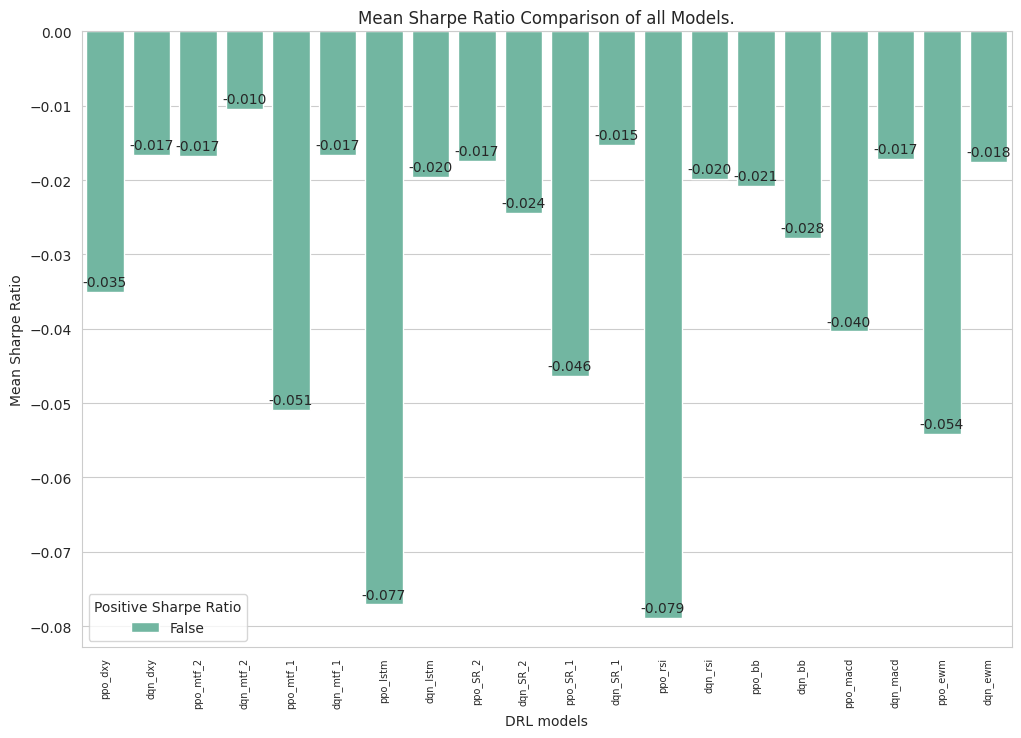

In [ ]:
# Calculate the mean of each column
means = sharpes_df.mean()

# Create a bar plot
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=means.index, y=means.values, hue= means>0, palette='Set2')

# Add mean annotations for all bars
for bar in ax.containers:
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f"{height:.3f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 2 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Plot graph
plt.title('Mean Sharpe Ratio Comparison of all Models.')
plt.ylabel('Mean Sharpe Ratio')
plt.legend(title='Positive Sharpe Ratio')
plt.xlabel('DRL models')
plt.xticks(rotation=90, fontsize=7)
plt.savefig('/content/drive/MyDrive/MScDataScienceArtificialIntelligence/3rdSemester/Dissertation/Build/images/sharpes_drl.svg')
plt.show()